# 2D Multi-element airfoil

This assignment will investigate a 2D multi-element airfoil or wing section with an extended flap. This is adapting the source-vortex panel method from Lesson 11 to compute the flow around two airfoils 


**Key concepts** 
1. each airfoil has its own vortex strength 
2. the trailing edge of the airfoil must follow the Kutta condition. 


## Part 1: Williams' test case 

The test of the theoretical solution. We will use a more popular airfoil NACA23012 for both the main wing section and flap. 

**Task**: to calculate the pressure coefficient on a multi-element wing section 

### Defining the Geometry and Discretization

In [14]:
#importing the libraries and modules needed 
import os
import numpy 
from scipy import integrate, linalg 
from matplotlib import pyplot

# integrate plots into the notebook 
%matplotlib inline 

In [15]:
# Importing the Data
MainFoil = numpy.genfromtxt('MainFoil_N=50.csv', delimiter =',')
FlapFoil = numpy.genfromtxt('FlapFoil_N=50.csv', delimiter = ',')

In [16]:
# Extracting Geometry from the Imported data
Main_x_ends, Flap_x_ends = MainFoil[:,0], FlapFoil[:,0]
Main_y_ends, Flap_y_ends = MainFoil[:,1], FlapFoil[:,1]

N = numpy.size(Main_x_ends)

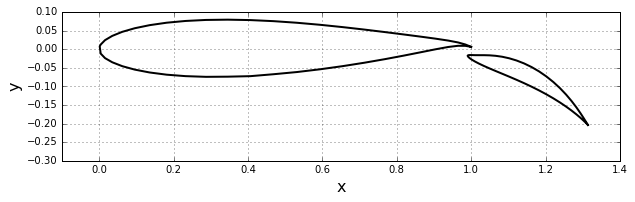

In [17]:
# Checking the geometry to see if it matches the diagram
width =10
pyplot.figure(figsize=(width,width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(Main_x_ends,Main_y_ends,color='k', linestyle='-', linewidth=2)
pyplot.plot(Flap_x_ends, Flap_y_ends, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.3,0.1);

Now that our geometry is loaded, We will calculate the velocities 

In [18]:
class Panel: 
    """
    Contains information related to panel
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initialized the panel. 
        
        sets the end-points and calculates the center-point, length, 
        and angle (with x-axis) of the panel. 
        Defines if the panel is located on the upper or lower surface 
        of the panel. 
        Initialized the source-strength, tangential velocity and pressure
        coefficent of the panel to zero. 
        
        Parameters:
        -----------
        xa: float
            x-coordinate of the first end-point. 
        ya: float
            y-coordinate of the first end-point. 
        xb: float 
            x-coordinate of the second end-point. 
        yb: float 
            y-coordinate of the second end-point. 
        """
        
        self.xa, self.ya = xa, ya #panel starting-point 
        self.xb, self.yb = xb, yb #panel ending point 
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2)
        
        # orientation of panel (angle between x-axis and panels normal)
        if xb-xa <=0.0: 
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa >0.0: 
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location 
        if self.beta <= numpy.pi:
            self.loc = 'upper'
        else: 
            self.loc = 'lower'
            
        self.sigma = 0.0
        self.vt = 0.0
        self.cp = 0.0

In [19]:
# Defining Panels using the points given
Main_panels = numpy.empty(N-1, dtype = object)
Flap_panels = numpy.empty(N-1, dtype = object)
for i in range(N-1):
    Main_panels[i] = Panel(Main_x_ends[i], Main_y_ends[i], 
                          Main_x_ends[i+1], Main_y_ends[i+1])
    Flap_panels[i] = Panel(Flap_x_ends[i], Flap_y_ends[i], 
                           Flap_x_ends[i+1], Flap_y_ends[i+1])

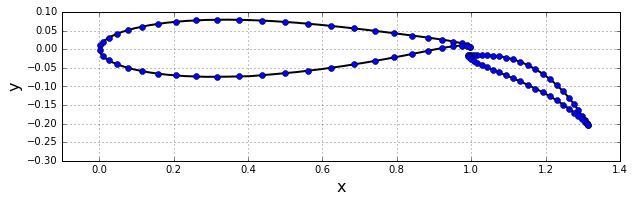

In [20]:
#plot the discretized geometry to check if panels are defined correctly
width= 10 
pyplot.figure(figsize=(width,width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(Main_x_ends,Main_y_ends,color='k', linestyle = '-', linewidth=2)
pyplot.plot(Flap_x_ends,Flap_y_ends,color='k', linestyle = '-', linewidth=2)
for i in range(N-1): 
    pyplot.plot(Main_panels[i].xc, Main_panels[i].yc, color = 'b', 
                    marker= 'o', markersize = 6)
    pyplot.plot(Flap_panels[i].xc, Flap_panels[i].yc, color = 'b', 
                    marker= 'o', markersize = 6)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.3,0.1);

### Free stream Conditions

In [21]:
class Freestream: 
    """
    Freestream conditions. 
    """
    def __init__(self, u_inf =1.0, alpha =0.0):
        """
        Sets the freestream speed and angle (in degrees). 
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0. 
        alpha: float, optional
            Angle of attack in degrees; 
            default: 0.0. 
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0

In [22]:
# define freestream conditions 
freestream = Freestream(u_inf=1.0, alpha = 0.0)

### Flow tangency boundary condition, Enforcing Kutta condition, and Building the linear system

In [23]:
# define the function for the integral part of the equation 
def integral(x, y, panel, dxdk, dydk): 
    """
    Evaluates the contribution from a panel at a given point. 
    
    Parameters 
    ----------
    x: float
        x-coordinate of target point. 
    y: float 
        y-coodrinate of target point. 
    panel: Panel object 
        Panel whose contribution is evaluated. 
    dxdk: float 
        Value of the derivative of x in a certain direction. 
    dydk: float 
        Value of the derivative of y in a certain direction. 
    
    Returns 
    -------
    Contribution fro the panel at a given point (x, y)
    """
    def integrand(s): 
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
               / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                 + (y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

Defining the source contribution normal function

In [24]:
def source_contribution_normal(panels): 
    """
    Builds the source contribution matrix for the normal velocity. 
    
    Parameters
    -----------
    panels: 1D array of Panel objects
        list of panels. 
    
    Returns 
    -------
    A: 2D Numpy array of floats
        Source contribution matrix
    """
    A = numpy.empty((panels.size, panels.size), dtype = float)
    # source contribution on a panel from itself 
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others 
    for i, panel_i in enumerate(panels): 
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc,
                                              panel_j, 
                                              numpy.cos(panel_i.beta), 
                                              numpy.sin(panel_i.beta))
    return A

In [29]:
# Define the vortex normal contribution
def vortex_contribution_normal(panels): 
    """
    Builds the vortex contribution for the normal velocity. 
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels
    
    Returns 
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix. 
    """
    A = numpy.empty((panels.size, panels.size), dtype = float)
    # vortex contribution on a panel from itself 
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others 
    for i, panel_i in enumerate(panels): 
        for j, panel_j in enumerate(panels): 
            if i != j: 
                A[i,j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                               panel_j, 
                                               numpy.sin(panel_i.beta), 
                                               -numpy.cos(panel_i.beta))
    return A

In [30]:
## Defining the panels

# Combining the panels for source calculation 
All_panels = numpy.append(Main_panels, Flap_panels)

#Defining source contribution 
A_source = source_contribution_normal(All_panels)

# Defining the vortex contribution
B_vortex_main = vortex_contribution_normal(Main_panels)
B_vortex_flap = vortex_contribution_normal(Flap_panels)

In [40]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = numpy.empty(A_source.shape[0]+1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b

In [41]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = numpy.empty((A_source.shape[0]+1, A_source.shape[1]+1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [42]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[-1].beta) )
    return b

In [45]:
A = build_singularity_matrix(A_source, B_vortex_main)
b = build_freestream_rhs(panels, freestream)

ValueError: could not broadcast input array from shape (50) into shape (100)

In [39]:
b
numpy.shape(b)

(101,)